### Data Preparation and Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [3]:
# Load dataset

df = pd.read_csv('exchange_rate.csv')
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
### summarize

df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [6]:
# Data Preparation
# Convert 'date' to datetime. Assuming format like '01-01-1990 00:00' based on snippet

df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)

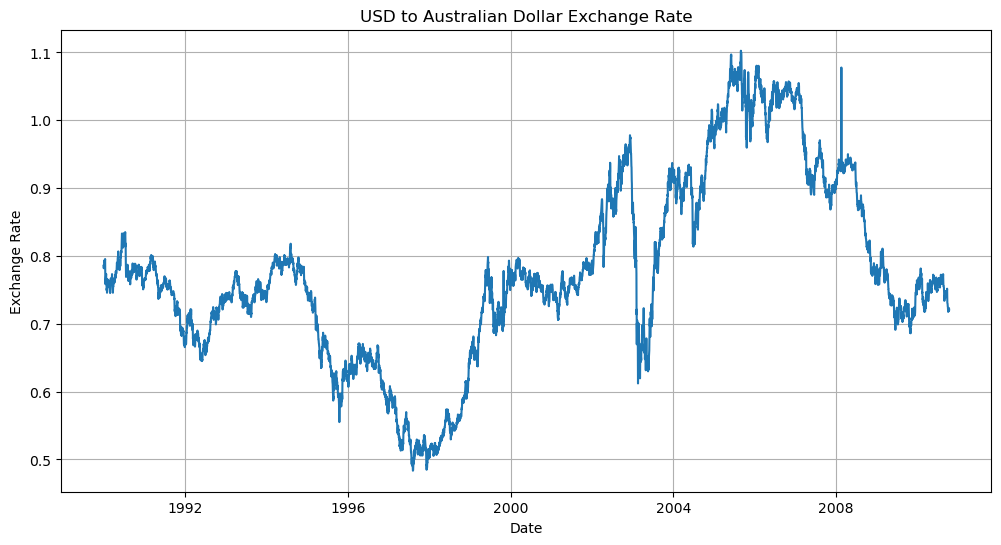

In [11]:
# Plot Time Series

plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'])
plt.title('USD to Australian Dollar Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)

In [12]:
### Check for missing values

missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Ex_rate    0
dtype: int64


### Model Building - ARIMA

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [13]:
# Stationarity Check (ADF Test)

result = adfuller(df['Ex_rate'])
print('\nADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.664994
p-value: 0.449233
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [16]:
# First order differencing

df_diff = df['Ex_rate'].diff().dropna()

In [17]:
# Check stationarity of differenced series

result_diff = adfuller(df_diff)
print('ADF Statistic (Differenced): %f' % result_diff[0])
print('p-value (Differenced): %f' % result_diff[1])

ADF Statistic (Differenced): -99.393431
p-value (Differenced): 0.000000


Text(0.5, 0.98, 'ACF and PACF for Differenced Series')

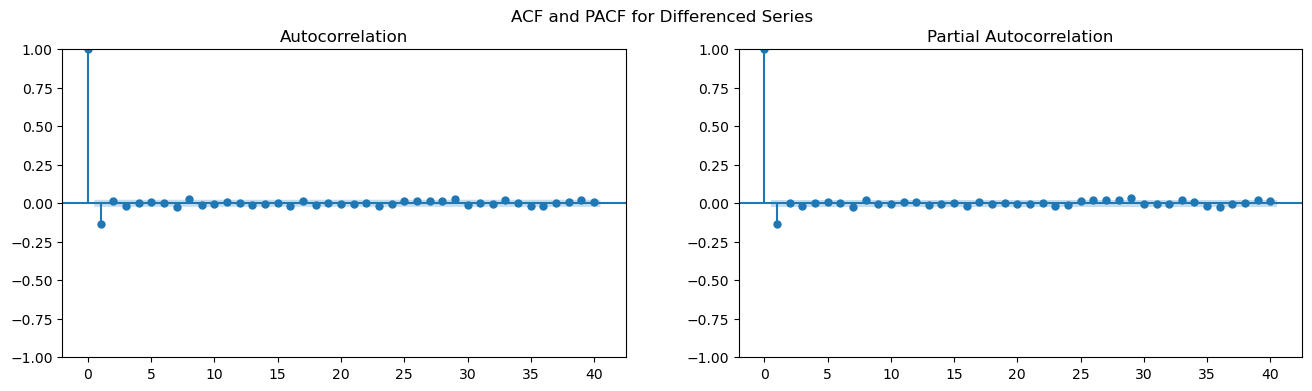

In [18]:
# Plot ACF and PACF

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df_diff, ax=axes[0], lags=40)
plot_pacf(df_diff, ax=axes[1], lags=40)
plt.suptitle('ACF and PACF for Differenced Series')

In [20]:
# Train-test split

train_size = int(len(df) - 30)
train, test = df['Ex_rate'][0:train_size], df['Ex_rate'][train_size:]

In [21]:
# ARIMA Model
# Using (p,d,q) = (1,1,1) as a starting point. Often sufficient for exchange rates.

arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=30)

/Applications/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Applications/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Applications/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [22]:
# Exponential Smoothing (Holt-Winters)
# Since there's no clear seasonality in exchange rates usually, we might use Holt's Linear Trend.

es_model = ExponentialSmoothing(train, trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=30)

/Applications/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Evaluation and Comparison

In [23]:
# Evaluate Models

def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [24]:
arima_metrics = calculate_metrics(test, arima_forecast)
es_metrics = calculate_metrics(test, es_forecast)

In [25]:
print(f"ARIMA Metrics: MAE={arima_metrics[0]:.5f}, RMSE={arima_metrics[1]:.5f}, MAPE={arima_metrics[2]:.5f}%")
print(f"ES Metrics:    MAE={es_metrics[0]:.5f}, RMSE={es_metrics[1]:.5f}, MAPE={es_metrics[2]:.5f}%")

ARIMA Metrics: MAE=0.01349, RMSE=0.01663, MAPE=1.86322%
ES Metrics:    MAE=0.01343, RMSE=0.01650, MAPE=1.85345%


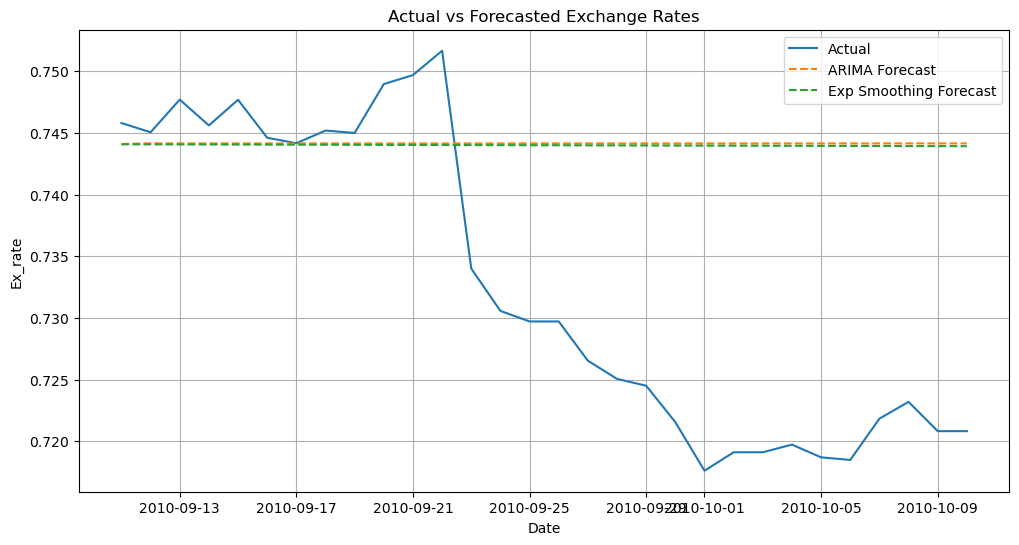

In [26]:
# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.plot(test.index, es_forecast, label='Exp Smoothing Forecast', linestyle='--')
plt.title('Actual vs Forecasted Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Ex_rate')
plt.legend()
plt.grid(True)

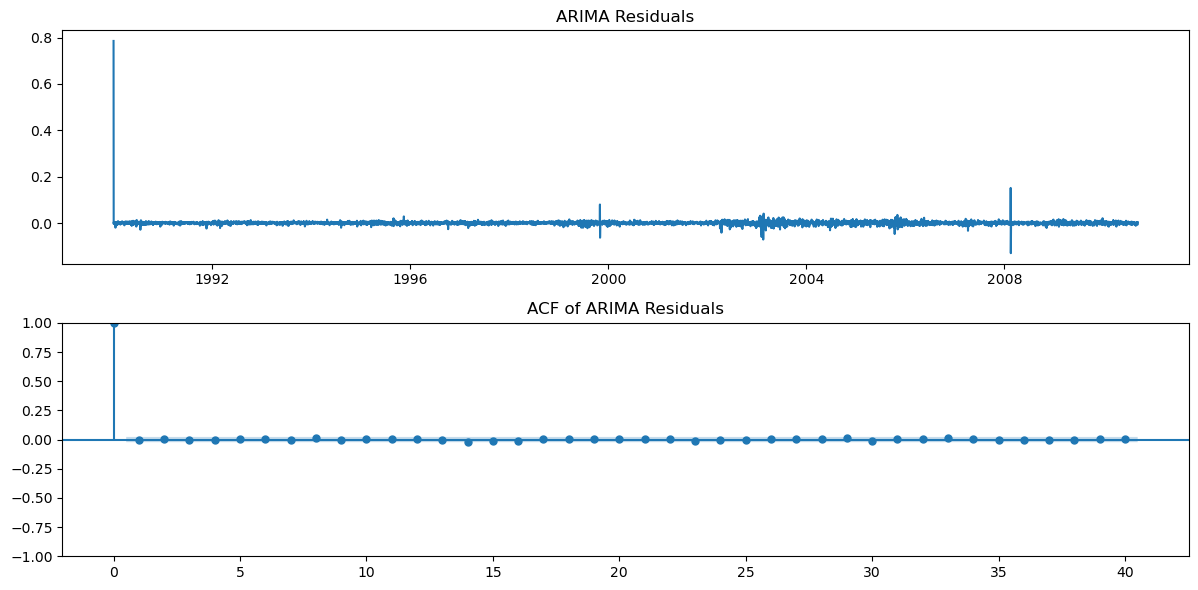

In [27]:
# Residual Analysis for ARIMA

residuals = arima_result.resid
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('ARIMA Residuals')
plt.subplot(2, 1, 2)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.title('ACF of ARIMA Residuals')
plt.tight_layout()

### Conclusion